# Table of Contents
 <p><div class="lev1 toc-item"><a href="#setup,-scale,-and-subset-object" data-toc-modified-id="setup,-scale,-and-subset-object-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>setup, scale, and subset object</a></div><div class="lev1 toc-item"><a href="#parametric-batch-correction-(ComBat)" data-toc-modified-id="parametric-batch-correction-(ComBat)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>parametric batch correction (ComBat)</a></div><div class="lev1 toc-item"><a href="#identify-variable-genes" data-toc-modified-id="identify-variable-genes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>identify variable genes</a></div><div class="lev1 toc-item"><a href="#PCA" data-toc-modified-id="PCA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA</a></div><div class="lev1 toc-item"><a href="#tsne" data-toc-modified-id="tsne-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>tsne</a></div><div class="lev2 toc-item"><a href="#assess-tsne" data-toc-modified-id="assess-tsne-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>assess tsne</a></div><div class="lev1 toc-item"><a href="#Find-Cluster-Markers" data-toc-modified-id="Find-Cluster-Markers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Find Cluster Markers</a></div><div class="lev2 toc-item"><a href="#find-clusterMarkers" data-toc-modified-id="find-clusterMarkers-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>find clusterMarkers</a></div><div class="lev2 toc-item"><a href="#analyze-clusterMarkers" data-toc-modified-id="analyze-clusterMarkers-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>analyze clusterMarkers</a></div><div class="lev2 toc-item"><a href="#select-clusterMarkers" data-toc-modified-id="select-clusterMarkers-63"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>select clusterMarkers</a></div>

# setup, scale, and subset object

In [1]:
# load libraries
library(Seurat)
library(dplyr)
library(Matrix)
library(abind)
source(paste0(.libPaths(), "/MarcusFuncs/statsFunction.R"))

IRdisplay::display_html("<style> .container { width:95% !important; } </style>")

Warning message:
“package ‘Seurat’ was built under R version 3.3.3”Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘dplyr’

The following object is masked from ‘package:Seurat’:

    arrange

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# read dge files into list and setup seurat object

dge <- list.files("/basiri/BNST/objects/dge/individual", pattern="*.txt", full.names=TRUE)
dge.list <- lapply(dge, read.table, sep="\t", header=TRUE, row.names=1)
names(dge.list) <- paste0(substr(dge, 113, nchar(dge)-38), ".data")
dge.list <- dge.list[order(names(dge.list))]

dge.seurat.list <- list()
for (i in seq_along(dge.list)){ 
dge.seurat.list[[i]] <- new("seurat", raw.data = dge.list[[i]])}
names(dge.seurat.list) <- substr(names(dge.list), 1, 4)

seurat.list <- list()
for (i in seq_along(dge.seurat.list)){  
seurat.list[[i]] <- Setup(dge.seurat.list[[i]], min.cells = 0, min.genes = 0, do.logNormalize = F, project = paste0(substr(names(dge.seurat.list[i]), 1, 4)), do.scale=F, do.center=F)}
names(seurat.list) <- substr(names(dge.list), 1, 4)

In [3]:
# merge seurat count object

counts <- MergeSeurat(seurat.list[[1]], seurat.list[[2]], project = "MLB005.counts", min.cells = 10, min.genes = 0, do.logNormalize = F, names.field = 1, add.cell.id1 = paste0(substr(names(dge.seurat.list[1]), 1, 4)), add.cell.id2 = paste0(substr(names(dge.seurat.list[2]), 1, 4)), do.scale=F, do.center=F)
for (i in 3:length(seurat.list)){counts <- MergeSeurat(counts, seurat.list[[i]], project = "MLB005.counts", min.cells = 10, min.genes = 0, do.logNormalize = F, names.field = 1, add.cell.id2 = paste0(substr(names(dge.seurat.list[i]), 1, 4)), do.scale=F, do.center=F)}

In [4]:
# add metadata--counts
# percentMito metadata
mitoGenes.counts <- grep("^mt-", rownames(counts@data), value = T)
percentMito.counts <- colSums(counts@data[mitoGenes.counts, ])/colSums(counts@data)
counts <- AddMetaData(counts, percentMito.counts, "percentMito")

# grep cells
cells.list <- list()
for (i in seq_along(dge.seurat.list)){ 
cells.list[[i]] <- grep(paste0(names(seurat.list[i])), rownames(counts@data.info), value = T)}
names(cells.list) <- paste0(substr(dge, 113, nchar(dge)-38), ".cells")

# batch metadata
batch.list <- list()
batch <- list("1" = c(1), "2" = c(2), "3" = c(3), "4" = c(4))

for (i in 1:length(seurat.list)){for(j in 1:length(batch)){
    if (i %in% batch[[j]]) batch.list[[i]] <- array(rep(paste0(names(batch[j])),length(cells.list[[i]])))}}

names(batch.list) <- paste0(substr(dge, 113, nchar(dge)-38), ".batch")
for (i in seq_along(seurat.list)){dimnames(batch.list[[i]]) <- list(cells.list[[i]])}       
batch <- do.call("abind", batch.list)
counts <- AddMetaData(counts, batch, "batch")
                                 
head(counts@data.info,3)
stats(counts)

,nGene,nUMI,orig.ident,percentMito,batch
GGTACATCTCCT.BFp1,6349,32787,BFp1,0.07673524,1
CATAATTTGTCT.BFp1,5444,20993,BFp1,0.04944452,1
TTATTTATACTT.BFp1,5583,21349,BFp1,0.04402870,1


raw max nGene:  6349 
raw min nGene:  1 
raw median nGene:  320 
raw mean nGene:  740.3925 
raw sd nGene:  934.1952 
raw sem nGene:  9.254448 
raw 95CI nGene:  721.8836 758.9014 

raw max nUMI:  32787 
raw min nUMI:  1 
raw median nUMI:  442 
raw mean nUMI:  1375.665 
raw sd nUMI:  2201.026 
raw sem nUMI:  21.8041 
raw 95CI nUMI:  1332.057 1419.273 

raw max percentMito:  1 
raw min percentMito:  0 
raw median percentMito:  0.05750599 
raw mean percentMito:  0.08702689 
raw sd percentMito:  0.08916977 
raw sem percentMito:  0.0008833454 
raw 95CI percentMito:  0.0852602 0.08879358 


In [5]:
# subset data-counts
counts <- SubsetData(counts, subset.name = "nGene", accept.low = 500)
counts <- SubsetData(counts, subset.name = "percentMito", accept.high = 0.05, accept.low = 0.001)
counts <- SubsetData(counts, subset.name = "nUMI", accept.high = 20000)

stats(counts)

raw max nGene:  5313 
raw min nGene:  501 
raw median nGene:  1435 
raw mean nGene:  1643.699 
raw sd nGene:  959.5768 
raw sem nGene:  19.22617 
raw 95CI nGene:  1605.247 1682.152 

raw max nUMI:  18392 
raw min nUMI:  591 
raw median nUMI:  2257 
raw mean nUMI:  3073.039 
raw sd nUMI:  2472.318 
raw sem nUMI:  49.53561 
raw 95CI nUMI:  2973.968 3172.111 

raw max percentMito:  0.04995459 
raw min percentMito:  0.001730104 
raw median percentMito:  0.03004979 
raw mean percentMito:  0.03024283 
raw sd percentMito:  0.01104345 
raw sem percentMito:  0.0002212677 
raw 95CI percentMito:  0.02980029 0.03068536 


In [6]:
# merge seurat-logMed

med = median(as.matrix(counts@data.info$nUMI))
logMed <- MergeSeurat(seurat.list[[1]], seurat.list[[2]], project = "logMed", min.cells = 10, min.genes = 0, do.logNormalize = T, total.expr = med, names.field = 1, add.cell.id1 = paste0(substr(names(dge.seurat.list[1]), 1, 4)), add.cell.id2 = paste0(substr(names(dge.seurat.list[2]), 1, 4)), do.scale=T, do.center=T)
for (i in 3:length(seurat.list)){logMed <- MergeSeurat(logMed, seurat.list[[i]], project = "logMed", min.cells = 10, min.genes = 0, do.logNormalize = T, total.expr = med, names.field = 1, add.cell.id2 = paste0(substr(names(dge.seurat.list[i]), 1, 4)), do.scale=T, do.center=T)}

In [7]:
# add metadata--logMed
# percentMito metadata
mitoGenes.logMed <- grep("^mt-", rownames(logMed@data), value = T)
percentMito.logMed <- colSums(expm1(logMed@data[mitoGenes.logMed, ]))/colSums(expm1(logMed@data))
logMed <- AddMetaData(logMed, percentMito.logMed, "percentMito")

# grep cells
cells.list <- list()
for (i in seq_along(dge.seurat.list)){ 
cells.list[[i]] <- grep(paste0(names(seurat.list[i])), rownames(logMed@data.info), value = T)}
names(cells.list) <- paste0(substr(dge, 113, nchar(dge)-38), ".cells")

# batch metadata
batch.list <- list()
batch <- list("1" = c(1), "2" = c(2), "3" = c(3), "4" = c(4))

for (i in 1:length(seurat.list)){for(j in 1:length(batch)){
    if (i %in% batch[[j]]) batch.list[[i]] <- array(rep(paste0(names(batch[j])),length(cells.list[[i]])))}}

names(batch.list) <- paste0(substr(dge, 113, nchar(dge)-38), ".batch")
for (i in seq_along(seurat.list)){dimnames(batch.list[[i]]) <- list(cells.list[[i]])}       
batch <- do.call("abind", batch.list)
logMed <- AddMetaData(logMed, batch, "batch")
                                 
head(logMed@data.info,3)

,nGene,nUMI,orig.ident,percentMito,batch
GGTACATCTCCT.BFp1,6349,32787,BFp1,0.07673524,1
CATAATTTGTCT.BFp1,5444,20993,BFp1,0.04944452,1
TTATTTATACTT.BFp1,5583,21349,BFp1,0.04402870,1


In [8]:
# subset data and save-logMed
logMed <- SubsetData(logMed, subset.name = "nGene", accept.low = 500)
logMed <- SubsetData(logMed, subset.name = "percentMito", accept.high = 0.05, accept.low = 0.001)
logMed <- SubsetData(logMed, subset.name = "nUMI", accept.high = 20000)
cat("total number of cells: ", nrow(logMed@data.info),"\n")

stats(logMed)

saveRDS(logMed, "/basiri/BNST/objects/subset/180219_MLB005.BNST.rds")
saveRDS(counts, "/basiri/BNST/objects/subset/180219_MLB005.BNST.counts.rds")

total number of cells:  2492 
raw max nGene:  5313 
raw min nGene:  501 
raw median nGene:  1434.5 
raw mean nGene:  1643.321 
raw sd nGene:  959.5696 
raw sem nGene:  19.22217 
raw 95CI nGene:  1604.877 1681.766 

raw max nUMI:  18392 
raw min nUMI:  591 
raw median nUMI:  2257 
raw mean nUMI:  3072.312 
raw sd nUMI:  2472.089 
raw sem nUMI:  49.52107 
raw 95CI nUMI:  2973.27 3171.354 

raw max percentMito:  0.05 
raw min percentMito:  0.001730104 
raw median percentMito:  0.03006249 
raw mean percentMito:  0.03025075 
raw sd percentMito:  0.01104833 
raw sem percentMito:  0.000221321 
raw 95CI percentMito:  0.02980811 0.0306934 


# parametric batch correction (ComBat)

In [1]:
# load libraries
library(Seurat)
library(dplyr)
library(Matrix)
library(abind)
library(reshape2)
library(sva)
library(scRNA.seq.funcs)
library(GGally)

IRdisplay::display_html("<style> .container { width:95% !important; } </style>")

Warning message:
“package ‘Seurat’ was built under R version 3.3.3”Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘dplyr’

The following object is masked from ‘package:Seurat’:

    arrange

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: mgcv
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.8-26. For overview type 'help("mgcv-package")'.
Loading required package: genefilter

Attaching package: ‘genefilter’

The following object is masked from ‘package:Seurat’:

    cv


Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



In [2]:
# read files in
logMed <- readRDS("/basiri/BNST/objects/subset/180219_MLB005.BNST.rds")

In [3]:
# remove zero variance genes from @data

data <- as.matrix(logMed@data)
logMed.var <- apply(data, 1, var)
zeroVarIndex <- which(logMed.var %in% 0)
zeroVarGenes <- rownames(data[c(zeroVarIndex),])

cat("number of zero variance genes: ", length(zeroVarGenes),"\n")

data <- data[!rownames(data) %in% zeroVarGenes, ]
logMed@data <- as(data, "dgCMatrix")

number of zero variance genes:  37 


In [4]:
# ComBat

# ComBat Model Matrix
logMed.combatPar.mod <- model.matrix(~as.numeric(nGene) + as.numeric(nUMI) + as.numeric(percentMito), data=logMed@data.info)

# ComBat parametric batch correction
logMed.combatPar <- ComBat(dat=logMed@data, batch=logMed@data.info$batch, mod=logMed.combatPar.mod, par.prior=T, prior.plots=F)
logMed.combatPar <- as.matrix(logMed.combatPar)

# save batch corrected matrix to @scale.data
logMed@scale.data <- as(logMed.combatPar, "matrix")
saveRDS(logMed, "/basiri/BNST/objects/batchCorrection/170219_MLB005.BNST.rds")

Found 4 batches
Adjusting for 3 covariate(s) or covariate level(s)
Standardizing Data across genes
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data


Saving 7 x 7 in image


pdf 
  2

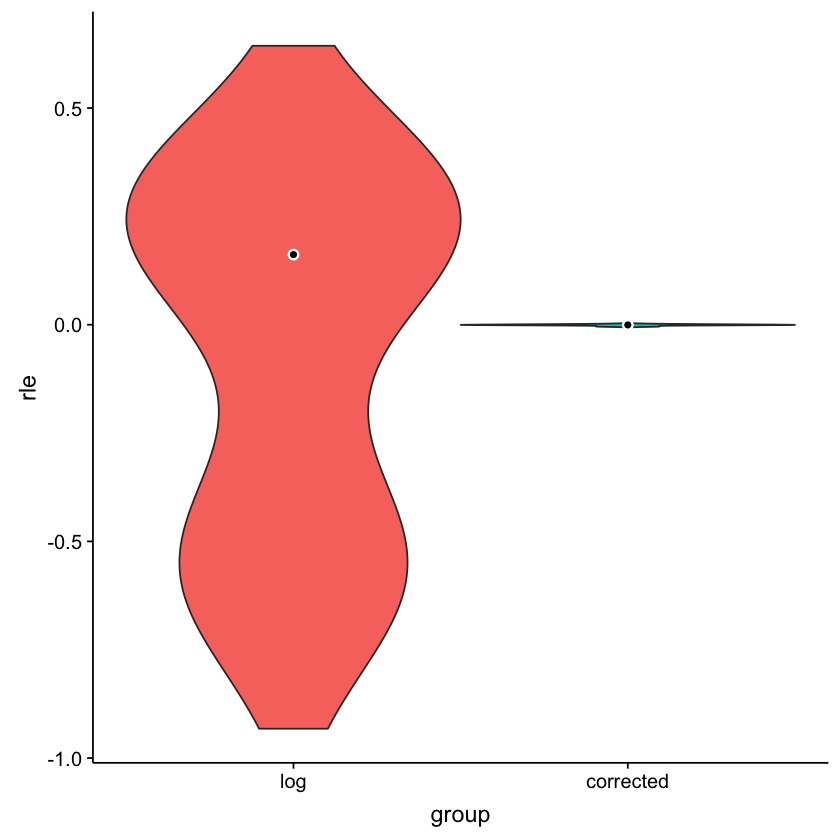

In [5]:
# assess batch correction -- Supplementary Figure 2D-E

origIdent <- sort(unique(logMed@data.info$orig.ident))
j = seq_along(origIdent)

cells.list <- list()
for (i in j){ 
cells.list[[i]] <- grep(paste0(origIdent[i]), rownames(logMed@data.info), value = T)}
names(cells.list) <- paste0(origIdent, ".cells")

# raw.means
raw <- as.matrix(logMed@raw.data)
raw.means.list <- list()
for (i in j){raw.means.list[[i]] <- rowMeans(raw[, cells.list[[i]]])}
names(raw.means.list) <- paste0(origIdent, ".cells")
     
# log.means
log <- as.matrix(logMed@data)
log.means.list <- list()
for (i in j){log.means.list[[i]] <- rowMeans(log[, cells.list[[i]]])}
names(log.means.list) <- paste0(origIdent, ".cells")
    
# corrected.means
corrected <- as.matrix(logMed@scale.data)
corrected.means.list <- list()
for (i in j){corrected.means.list[[i]] <- rowMeans(corrected[, cells.list[[i]]])}
names(corrected.means.list) <- paste0(origIdent, ".cells")
 
# calculate and plot rle
log.rle <- calc_cell_RLE(expm1(log))
corrected.rle <- calc_cell_RLE(expm1(corrected))
rle <- melt(cbind(log = log.rle, corrected = corrected.rle))[,2:3]
names(rle) <- c("group", "rle")

ggplot(rle, aes(x=group, y=rle, fill=group)) + geom_violin(scale="width", width=1, trim=F, adjust = 3) + stat_summary(fun.y=median, geom="point", shape=21, size=2, stroke=1, fill="black", color="white") + theme(legend.position="none")
ggsave("/basiri/BNST/figs/batchCorrection/rle/170219_MLB005.BNST.RLE.pdf")

# plot mean expression Pearsons R across animals
pdf("/basiri/BNST/figs/batchCorrection/ggcorr/170219_MLB005.BNST.ggcorr.pdf")
ggcorr(raw.means.list, hjust = 0.75, size = 4, low = "lightgrey", high = "#055977", layout.exp = 1, midpoint = 0.9, limits = c(0.8, 1), label = T, label_round = 2, label_size = 5, legend.position = "top", name="raw")
ggcorr(log.means.list, hjust = 0.75, size = 4, low = "lightgrey", high = "#055977", layout.exp = 1, midpoint = 0.9, limits = c(0.8, 1), label = T, label_round = 2, label_size = 5, legend.position = "top", name="log")
ggcorr(corrected.means.list, hjust = 0.75, size = 4, low = "lightgrey", high = "#055977", layout.exp = 1, midpoint = 0.9, limits = c(0.8, 1), label = T, label_round = 2, label_size = 5, legend.position = "top", name="corrected")
dev.off()

# identify variable genes

In [1]:
# load libraries
library(Seurat)
library(dplyr)
library(Matrix)
library(abind)

IRdisplay::display_html("<style> .container { width:95% !important; } </style>")

Warning message:
“package ‘Seurat’ was built under R version 3.3.3”Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘dplyr’

The following object is masked from ‘package:Seurat’:

    arrange

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# read files in
logMed <- readRDS("/basiri/BNST/objects/batchCorrection/170219_MLB005.BNST.rds")

In [3]:
# identify commGenes

dge <- list.files("/basiri/BNST/objects/dge/individual", pattern="*.txt", full.names=TRUE)
dge.list <- lapply(dge, read.table, sep="\t", header=TRUE, row.names=1)

# make vector of matching genes across animals in each group
genes.list <- list()
for (i in seq_along(dge.list)){genes.list[[i]] <- rownames(as.vector(dge.list[[i]]))}
names(genes.list) <- paste0(substr(dge, 113, nchar(dge)-38), ".genes")
list2env(genes.list ,.GlobalEnv)

commGenes <- unique(Reduce(intersect, list(BFp1.genes, BGp1.genes, BHp1.genes, BIp1.genes)))
cat("number of commGenes: ", length(commGenes),"\n")

# combine unique commGenes by group
commGenes <- Reduce(intersect, list(rownames(logMed@scale.data), commGenes))
cat("number of unique commGenes: ", length(commGenes),"\n")

logMed@var.genes <- as(commGenes, "character")
saveRDS(logMed, "/basiri/BNST/objects/genes/170219_MLB005.BNST.commGenes.rds")
saveRDS(commGenes, "/basiri/BNST/objects/genes/170219_MLB005.BNST.commGenes.genes.rds")

<environment: R_GlobalEnv>

number of commGenes:  15083 
number of unique commGenes:  14549 


In [4]:
# identify commVarGenes

pdf("/basiri/BNST/figs/genes/meanVarPlot/170219_MLB005.BNST.meanVar.pdf")
logMed <- MeanVarPlot(logMed, fxn.x = expMean, fxn.y = logVarDivMean, x.low.cutoff = 0.01, x.high.cutoff = 10, y.cutoff = 0.5, do.contour = T, do.text = T, cex.use = 0.2, contour.lwd = 1, num.bin = 20)
logMed.noTxt <- MeanVarPlot(logMed, fxn.x = expMean, fxn.y = logVarDivMean, x.low.cutoff = 0.01, x.high.cutoff = 10, y.cutoff = 0.5, do.contour = T, do.text = F, cex.use = 0.2, contour.lwd = 1, num.bin = 20)
dev.off()

commVarGenes <- Reduce(intersect, list(commGenes, as.vector(logMed@var.genes)))

cat("number of VarGenes: ", length(logMed@var.genes),"\n")
cat("number of commVarGenes: ", length(commVarGenes),"\n")

logMed@var.genes <- as(commVarGenes, "character")
saveRDS(logMed, "/basiri/BNST/objects/genes/170219_MLB005.BNST.rds")

pdf 
  2

number of VarGenes:  2208 
number of commVarGenes:  2206 


# PCA

In [1]:
#load libraries

library(Seurat)

IRdisplay::display_html("<style> .container { width:95% !important; } </style>")

Warning message:
“package ‘Seurat’ was built under R version 3.3.3”Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
# read objects
MLB005.commVarGenes <- readRDS("/basiri/BNST/objects/genes/170219_MLB005.BNST.rds")

In [3]:
# run PCA and project--commVarGenes

pca <- PCA(MLB005.commVarGenes, pc.genes = MLB005.commVarGenes@var.genes, pcs.store = 120, do.print = F)
pca <- ProjectPCA(pca, pcs.store = 120, replace.pc = T, do.center=T, do.print = F)
saveRDS(pca, "/basiri/BNST/objects/pca/180304_MLB005.BNST.pca.rds")

# tsne

##### This portion of code was run on a high-performance cluster computing environment. See Methods for details. 

In [1]:
# run tsne

library(devtools)
library(Seurat)
library(dplyr)
library(Matrix)

dims = 20
res = 1.3

filename <- paste0("180304_MLB005.BNST.tsne",dims,".perp30.res",res,".rds")

MLB005 <- readRDS("/proj/stuberlb/Users/marcus/dropseq/data/MLB005_170907/seurat/objects/pca/180304_MLB005.BNST.pca.rds")
MLB005 <- FindClusters(MLB005, pc.use = 1:dims, resolution = res, print.output = T, save.SNN = T, algorithm = 2, k.param = 30)
MLB005 <- RunTSNE(MLB005, dims.use = 1:dims, perplexity = 30)
saveRDS(MLB005, paste0("/proj/stuberlb/Users/marcus/dropseq/data/MLB005_170907/seurat/objects/tsne/",filename))

Warning message:
“package ‘Seurat’ was built under R version 3.3.3”Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘Seurat’

The following object is masked from ‘package:devtools’:

    setup


Attaching package: ‘dplyr’

The following object is masked from ‘package:Seurat’:

    arrange

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message in gzfile(file, "rb"):
“cannot open compressed file '/proj/stuberlb/Users/marcus/dropseq/data/MLB005_170907/seurat/objects/pca/180304_MLB005.BNST.pca.rds', probable reason 'No such file or directory'”

ERROR: Error in gzfile(file, "rb"): cannot open the connection


## assess tsne

In [1]:
#load libraries
library(Seurat)
library(viridis)
library(reshape2)

orangeBlue <- colorRampPalette(c("#3794bf", "#FFFFFF", "#df8640"))(1000)
orangeBlueDark <- colorRampPalette(c("#215872", "#FFFFFF", "#995c2c"))(1000)

IRdisplay::display_html("<style> .container { width:95% !important; } </style>")

Warning message:
“package ‘Seurat’ was built under R version 3.3.3”Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: viridisLite


In [2]:
# read objects

tsne <- readRDS("/basiri/BNST/objects/tsne/180304_MLB005.BNST.rds")
commGenes <- readRDS("/basiri/BNST/objects/genes/170219_MLB005.BNST.commGenes.genes.rds")

pdf 
  2

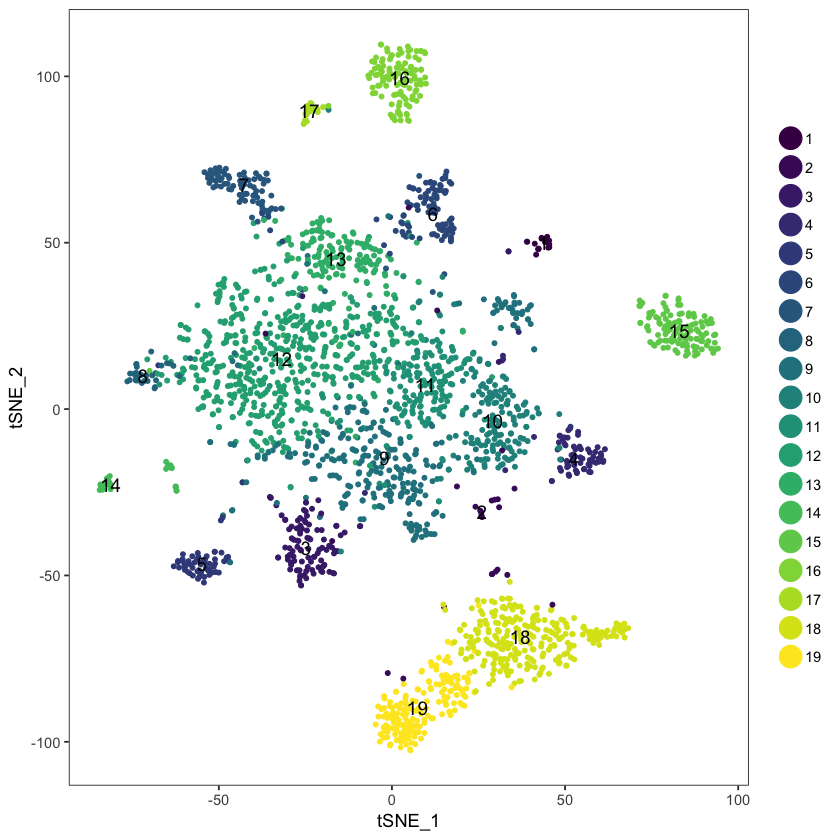

In [3]:
# BuildClusterTree and plot tsne -- Supplementary Figure 2C

tsne <- BuildClusterTree(tsne, genes.use = commGenes, do.plot = F, do.reorder = T, reorder.numeric = T)
saveRDS(tsne, "/basiri/BNST/objects/tree/180304_MLB005.BNST.tree.rds")

pdf("/basiri/BNST/figs/tsne/tsnePlot/180304_MLB005.BNST.tsnePlot.pdf")
TSNEPlot(tsne, do.label = F, pt.size = 1)
TSNEPlot(tsne, do.label = F, pt.size = 1, group.by="orig.ident")
dev.off()

TSNEPlot(tsne, do.label = T, pt.size = 1)

num cells cluster  1 : 16 
num cells cluster  2 : 25 
num cells cluster  3 : 102 
num cells cluster  4 : 72 
num cells cluster  5 : 58 
num cells cluster  6 : 93 
num cells cluster  7 : 83 
num cells cluster  8 : 30 
num cells cluster  9 : 290 
num cells cluster  10 : 171 
num cells cluster  11 : 147 
num cells cluster  12 : 545 
num cells cluster  13 : 156 
num cells cluster  14 : 27 
num cells cluster  15 : 121 
num cells cluster  16 : 116 
num cells cluster  17 : 21 
num cells cluster  18 : 252 
num cells cluster  19 : 167 

mean nUMI cluster  1 : 909 
mean nUMI cluster  2 : 3094.88 
mean nUMI cluster  3 : 1732.931 
mean nUMI cluster  4 : 2994.458 
mean nUMI cluster  5 : 3260.603 
mean nUMI cluster  6 : 2940.29 
mean nUMI cluster  7 : 3694.06 
mean nUMI cluster  8 : 3732.433 
mean nUMI cluster  9 : 3292.914 
mean nUMI cluster  10 : 3816.485 
mean nUMI cluster  11 : 3151.898 
mean nUMI cluster  12 : 4358.301 
mean nUMI cluster  13 : 4899.968 
mean nUMI cluster  14 : 1428.111 
mean nU

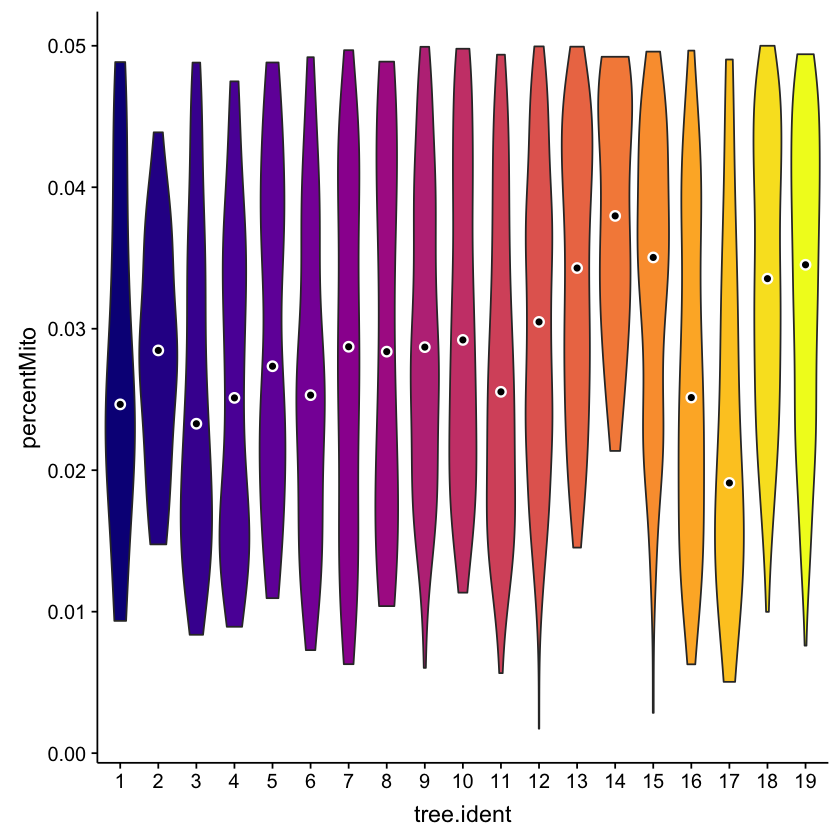

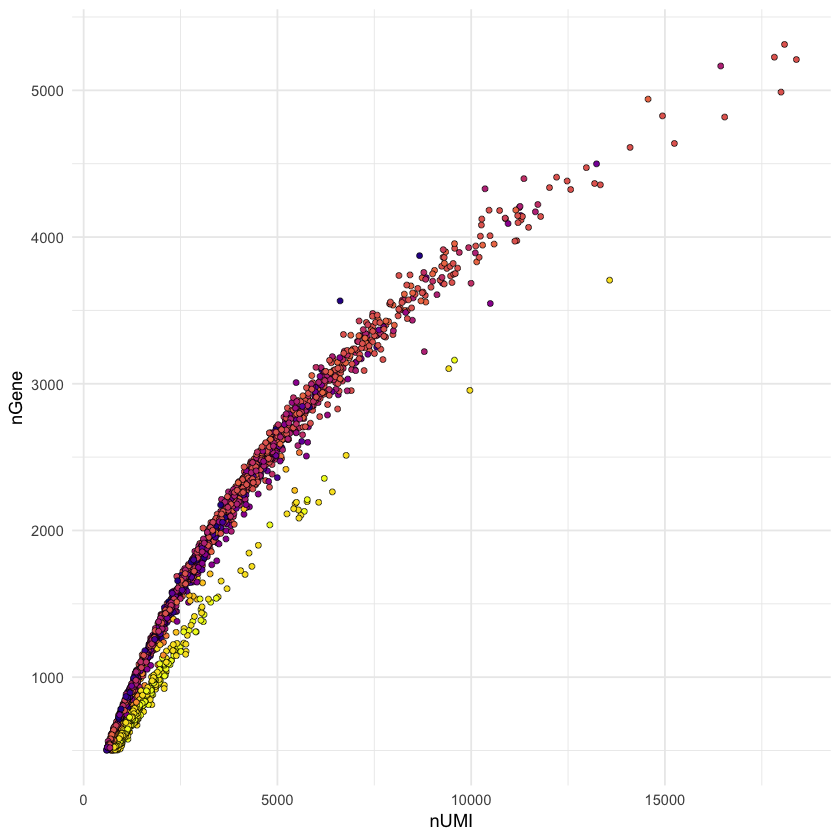

In [4]:
# cluster num cells, mean nUMI, mean percentMito -- Supplementary Figure 2F and 2H

for(i in 1:max(tsne@ident)){cat('num cells cluster ',i,':', nrow(subset(tsne@data.info, tree.ident == i)), "\n")}
cat("\n")
for(i in 1:max(tsne@ident)){cat('mean nUMI cluster ',i,':', mean(subset(tsne@data.info, tree.ident == i)$nUMI), "\n")}
cat("\n")
for(i in 1:max(tsne@ident)){cat('mean nGene cluster ',i,':', mean(subset(tsne@data.info, tree.ident == i)$nGene), "\n")}
cat("\n")
for(i in 1:max(tsne@ident)){cat('mean percentMito cluster ',i,':', mean(subset(tsne@data.info, tree.ident == i)$percentMito), "\n")}

tsne.info <- as.data.frame(tsne@data.info)
tsne.info$tree.ident <- as.factor(tsne.info$tree.ident)

clust.colors <-  c(plasma(length(unique(tsne.info$tree.ident)), alpha = 1))[match(unique(tsne.info$tree.ident), unique(tsne.info$tree.ident))]

ggplot(tsne.info, aes(x=tree.ident, y=percentMito, fill=tree.ident)) + geom_violin(width=1) + stat_summary(fun.y=median, geom="point", shape=21, size=2, stroke=1, fill="black", color="white") + theme(legend.position="none") + scale_fill_manual(values=as.vector(clust.colors))
ggsave("/basiri/BNST/figs/subset/vlnPlot/180304_MLB005.BNST.tree.pctMito.vlnPlot.svg", width = 12, height = 4, dpi = 300)

point.colors <-  c(rep("#BD3786FF", 12), rep("grey50", 7)) 
ggplot(tsne.info, aes(x=nUMI, y=nGene, fill=tree.ident)) + geom_point(shape=21, size=1.5, stroke=0.25, color="black") + scale_fill_manual(values=as.vector(clust.colors)) + theme_minimal() + theme(legend.position="none") 
ggsave("/basiri/BNST/figs/subset/genePlot/180304_MLB005.BNST.tree.nUMIxnGene.vlnPlot.svg", width = 12, height = 4, dpi = 300)

# Find Cluster Markers

## find clusterMarkers

In [1]:
# load libraries

library(Seurat)
library(Matrix)
library(dplyr)

IRdisplay::display_html("<style> .container { width:95% !important; } </style>")

Warning message:
“package ‘Seurat’ was built under R version 3.3.3”Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘dplyr’

The following object is masked from ‘package:Seurat’:

    arrange

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# read objects

tsne <- readRDS("/basiri/BNST/objects/tree/180304_MLB005.BNST.tree.rds")
commGenes <- readRDS("/basiri/BNST/objects/genes/170219_MLB005.BNST.commGenes.genes.rds")

In [3]:
# find markersClustV

markersClust.1vN24 <- FindMarkers(tsne, 1, c(2:13), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.2vN28 <- FindMarkers(tsne, 2, c(3:13), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.3vN33 <- FindMarkers(tsne, 3, c(4:5), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.4v5 <- FindMarkers(tsne, 4, c(5), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.5v4 <- FindMarkers(tsne, 5, c(4), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.6v7 <- FindMarkers(tsne, 6, c(7), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.7v6 <- FindMarkers(tsne, 7, c(6), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.8vN34 <- FindMarkers(tsne, 8, c(9:13), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.9v10 <- FindMarkers(tsne, 9, c(10), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.10v9 <- FindMarkers(tsne, 10, c(9), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.11vN37 <- FindMarkers(tsne, 11, c(12:13), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.12v13 <- FindMarkers(tsne, 12, c(13), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.13v12 <- FindMarkers(tsne, 13, c(12), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.14vN23 <- FindMarkers(tsne, 14, c(15:19), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.15v16 <- FindMarkers(tsne, 15, c(16), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.16v15 <- FindMarkers(tsne, 16, c(15), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.17vN27 <- FindMarkers(tsne, 17, c(18:19), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.18v19 <- FindMarkers(tsne, 18, c(19), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)
markersClust.19v18 <- FindMarkers(tsne, 19, c(18), genes.use = commGenes, thresh.use = 0, test.use = "bimod", min.pct = 0, min.diff.pct = 0, only.pos = F)

markersClust.1vN24 <- cbind(markersClust.1vN24, gene=rownames(markersClust.1vN24))
markersClust.2vN28 <- cbind(markersClust.2vN28, gene=rownames(markersClust.2vN28))
markersClust.3vN33 <- cbind(markersClust.3vN33, gene=rownames(markersClust.3vN33))
markersClust.4v5 <- cbind(markersClust.4v5, gene=rownames(markersClust.4v5))
markersClust.5v4 <- cbind(markersClust.5v4, gene=rownames(markersClust.5v4))
markersClust.6v7 <- cbind(markersClust.6v7, gene=rownames(markersClust.6v7))
markersClust.7v6 <- cbind(markersClust.7v6, gene=rownames(markersClust.7v6))
markersClust.8vN34 <- cbind(markersClust.8vN34, gene=rownames(markersClust.8vN34))
markersClust.9v10 <- cbind(markersClust.9v10, gene=rownames(markersClust.9v10))
markersClust.10v9 <- cbind(markersClust.10v9, gene=rownames(markersClust.10v9))
markersClust.11vN37 <- cbind(markersClust.11vN37, gene=rownames(markersClust.11vN37))
markersClust.12v13 <- cbind(markersClust.12v13, gene=rownames(markersClust.12v13))
markersClust.13v12 <- cbind(markersClust.13v12, gene=rownames(markersClust.13v12))
markersClust.14vN23 <- cbind(markersClust.14vN23, gene=rownames(markersClust.14vN23))
markersClust.15v16 <- cbind(markersClust.15v16, gene=rownames(markersClust.15v16))
markersClust.16v15 <- cbind(markersClust.16v15, gene=rownames(markersClust.16v15))
markersClust.17vN27 <- cbind(markersClust.17vN27, gene=rownames(markersClust.17vN27))
markersClust.18v19 <- cbind(markersClust.18v19, gene=rownames(markersClust.18v19))
markersClust.19v18 <- cbind(markersClust.19v18, gene=rownames(markersClust.19v18))

saveRDS(markersClust.1vN24, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.1vN24.rds")
saveRDS(markersClust.2vN28, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.2vN28.rds")
saveRDS(markersClust.3vN33, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.3vN33.rds")
saveRDS(markersClust.4v5, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.4v5.rds")
saveRDS(markersClust.5v4, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.5v4.rds")
saveRDS(markersClust.6v7, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.6v7.rds")
saveRDS(markersClust.7v6, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.7v6.rds")
saveRDS(markersClust.8vN34, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.8vN34.rds")
saveRDS(markersClust.9v10, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.9v10.rds")
saveRDS(markersClust.10v9, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.10v9.rds")
saveRDS(markersClust.11vN37, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.11vN37.rds")
saveRDS(markersClust.12v13, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.12v13.rds")
saveRDS(markersClust.13v12, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.13v12.rds")
saveRDS(markersClust.14vN23, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.14vN23.rds")
saveRDS(markersClust.15v16, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.15v16.rds")
saveRDS(markersClust.16v15, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.16v15.rds")
saveRDS(markersClust.17vN27, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.17vN27.rds")
saveRDS(markersClust.18v19, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.18v19.rds")
saveRDS(markersClust.19v18, "/basiri/BNST/objects/clusterMarkers/individual/180312_MLB005.BNST.tree.markersClust.19v18.rds")

## analyze clusterMarkers

In [1]:
# load libraries

library(Seurat)
library(Matrix)
library(dplyr)
library(abind)
library(reshape2)

IRdisplay::display_html("<style> .container { width:95% !important; } </style>")

Warning message:
“package ‘Seurat’ was built under R version 3.3.3”Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘dplyr’

The following object is masked from ‘package:Seurat’:

    arrange

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# read objects and markersClustV

tsne <- readRDS("/basiri/BNST/objects/tree/180304_MLB005.BNST.tree.rds")
commGenes <- readRDS("/basiri/BNST/objects/genes/170219_MLB005.BNST.commGenes.genes.rds")

# read markersClustV into list

markersClustV <- list.files("/basiri/BNST/objects/clusterMarkers/individual", pattern="*.rds", full.names=TRUE)
markersClustV.list <- lapply(markersClustV, readRDS)
names(markersClustV.list) <- substr(markersClustV, 234, nchar(markersClustV)-4)
markersClustV.list <- markersClustV.list[c('markersClust.1vN24', 'markersClust.2vN28', 'markersClust.3vN33', 'markersClust.4v5', 'markersClust.5v4', 'markersClust.6v7', 'markersClust.7v6', 'markersClust.8vN34', 'markersClust.9v10', 'markersClust.10v9', 'markersClust.11vN37', 'markersClust.12v13', 'markersClust.13v12', 'markersClust.14vN23', 'markersClust.15v16', 'markersClust.16v15', 'markersClust.17vN27', 'markersClust.18v19', 'markersClust.19v18')]

In [3]:
# create matrix of pVals for all clusters

markersClustV.pVal.list <- lapply(markersClustV.list, function(x) {x[c("gene", "p_val")]})

for (i in seq_along(markersClustV.pVal.list)){colnames(markersClustV.pVal.list[[i]]) <- c("gene", paste0("c",i, ".pVal"))}

markersClustV.pVal <- Reduce(function(x,y)merge(x,y,by="gene", all=TRUE), markersClustV.pVal.list)

row.names(markersClustV.pVal) <- markersClustV.pVal[,1]
markersClustV.pVal <- markersClustV.pVal[,-1]

cat("number of genes markersClustV.pVal: ",nrow(markersClustV.pVal),"\n")

saveRDS(markersClustV.pVal, "/basiri/BNST/objects/genes/180312_MLB005.BNST.markersClustV.pVal.rds")
write.table(markersClustV.pVal, "/basiri/BNST/objects/genes/180312_MLB005.BNST.markersClustV.pVal.txt", sep="\t", col.names=NA)

number of genes markersClustV.pVal:  14549 


In [4]:
# create cluster average expression matrix

clust.avg <- AverageExpression(tsne, genes.use = commGenes, return.seurat = F)
colnames(clust.avg) <- c(paste0("c",seq_along(colnames(clust.avg)), ".avg"))
cat("number of genes clust.avg:", nrow(clust.avg), "\n")
saveRDS(clust.avg, "/basiri/BNST/objects/genes/180312_MLB005.BNST.clustAvg.rds")
write.table(clust.avg, "/basiri/BNST/objects/genes/180312_MLB005.BNST.clustAvg.txt", sep="\t", col.names=NA)

number of genes clust.avg: 14549 


In [5]:
# create matrix of percent positive cells per cluster

rawData <- as.matrix(tsne@raw.data)

# create list of cell names for each cluster
tsne.ident <- as.matrix(tsne@ident)
cells <- c(NA)
cells.list <- list()
for(i in 1:max(tsne@ident)){cells <- names(tsne.ident[tsne.ident[,1]==i,])
                assign(paste0('c',i,'.cells'), cells)
        cells.list[[i]] <- cells                         
        setNames(cells.list, paste0('c',i,'.cells'))}

# slice rawData by cluster
cells.rawData <- c(NA)
cells.rawData.list <- list()
for(i in 1:max(tsne@ident)){cells.rawData <- rawData[,cells.list[[i]]]
                assign(paste0('c',i,'.cells.rawData'), cells.rawData)
        cells.rawData.list[[i]] <- cells.rawData                         
        setNames(cells.rawData.list, paste0('c',i,'.cells.rawData'))}

# sums by gene per cluster
sums <- c(NA)
sums.list <- list()
for(i in 1:max(tsne@ident)){sums <- rowSums(cells.rawData.list[[i]] != 0)
                assign(paste0('c',i,'.sums'), sums)
        sums.list[[i]] <- sums                         
        setNames(sums.list, paste0('c',i,'.sums'))}

# pct by gene per cluster
pct <- c(NA)
pct.list <- list()
for(i in 1:max(tsne@ident)){pct <- sums.list[[i]]/length(cells.list[[i]])
                assign(paste0('c',i,'.pct'), pct)
        pct.list[[i]] <- pct                         
        setNames(pct.list, paste0('c',i,'.pct'))}

pct <- data.frame(sapply(pct.list,c))

for(i in 1:max(tsne@ident)){names(pct)[i] <- c(paste0('c',i,'.pct'))}

saveRDS(pct, "/basiri/BNST/objects/genes/180312_MLB005.BNST.pct.rds")
write.table(pct, "/basiri/BNST/objects/genes/180312_MLB005.BNST.pct.txt", sep="\t", col.names=NA)

## select clusterMarkers

In [1]:
# load libraries

library(Seurat)
library(Matrix)
library(dplyr)
library(matrixStats)
library(made4)
library(reshape2)
library(viridis)
library(RColorBrewer)

orangeBlue <- colorRampPalette(c("#3794bf", "#FFFFFF", "#df8640"))(256)
orangeBlueDark <- colorRampPalette(c("#115372", "#FFFFFF", "#cc6e00"))(1000)

IRdisplay::display_html("<style> .container { width:95% !important; } </style>")

Warning message:
“package ‘Seurat’ was built under R version 3.3.3”Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘dplyr’

The following object is masked from ‘package:Seurat’:

    arrange

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘matrixStats’

The following object is masked from ‘package:dplyr’:

    count

Loading required package: ade4
Loading required package: RColorBrewer
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: scatterplot3d
Loading required package: viridisLite


In [2]:
# read files in

tsne <- readRDS("/basiri/BNST/objects/tree/180304_MLB005.BNST.tree.rds")
commGenes <- readRDS("/basiri/BNST/objects/genes/170219_MLB005.BNST.commGenes.genes.rds")

clust.avg <- readRDS("/basiri/BNST/objects/genes/180312_MLB005.BNST.clustAvg.rds")
pct <- readRDS("/basiri/BNST/objects/genes/180312_MLB005.BNST.pct.rds")
markersClustV.pVal <- readRDS("/basiri/BNST/objects/genes/180312_MLB005.BNST.markersClustV.pVal.rds")

clust.avg <- as.matrix(clust.avg)
pct <- as.matrix(pct)
markersClustV.pVal <- as.matrix(markersClustV.pVal)

Saving 7 x 7 in image


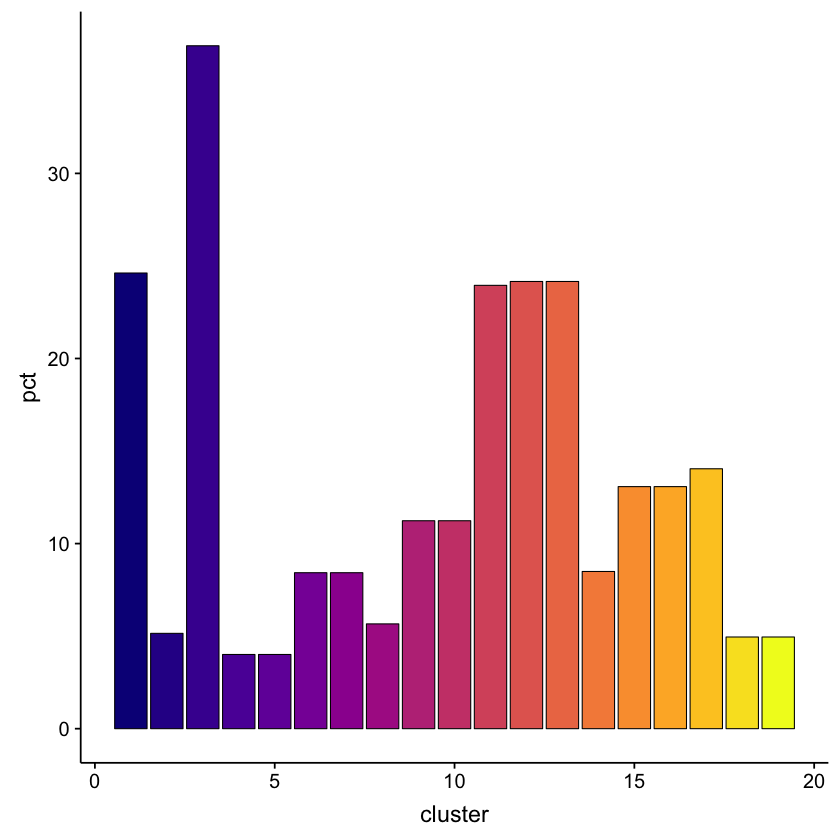

In [3]:
# pct sig genes by cluster -- Supplementary Figure 2G

pct.min = 0
pVal.max = 10e-3

markersClustV.pVal <- as.matrix(markersClustV.pVal)
pct <- as.matrix(pct)

markersClustV.pVal.subs <- list()
for (i in 1:ncol(markersClustV.pVal)) {markersClustV.pVal.subs[[i]] <- names(subset(markersClustV.pVal[,i], markersClustV.pVal[,i] <= pVal.max))}

pct.subs <- list()
for (i in 1:ncol(pct)) {pct.subs[[i]] <- names(subset(pct[,i], pct[,i] >= pct.min))}

intersect <- list()
for (i in 1:ncol(pct)) {intersect[[i]] <- intersect(unlist(pct.subs[[i]]), unlist(markersClustV.pVal.subs[[i]]))}

pctSig <- list()
for (i in 1:ncol(markersClustV.pVal)) {pctSig[[i]] <- (((length(na.omit(intersect[[i]])))/(length(na.omit(markersClustV.pVal[,i]))))*100)}
pctSig <- as.data.frame(cbind(cluster = 1:ncol(markersClustV.pVal), pct = unlist(pctSig)))

clust.colors <-  c(plasma(ncol(markersClustV.pVal)), alpha = 1)[match(colnames(markersClustV.pVal), unique(colnames(markersClustV.pVal)))]

ggplot(pctSig, aes(x=cluster, y=pct, fill=factor(cluster))) + geom_bar(stat="identity", color="black", size=0.3) + scale_fill_manual(values=as.character(clust.colors)) + theme(legend.position="none") 
ggsave("/basiri/BNST/figs/clusterMarkers/pVal/180312_MLB005.BNST.pctSig.pdf")

In [4]:
# subset genes by pct.min, pVal.max, avg.min
pct.min = 0.3
pVal.max = 10e-3
avg.min = 0
avg.mult.mean = 1

pct.list <- list()
for (i in seq_along(colnames(pct))){pct.list[[i]] <- names(subset(pct[,i], pct[,i] >= pct.min))}

avg.list <- list()
for (i in seq_along(colnames(clust.avg))){avg.list[[i]] <- names(subset(expm1(clust.avg[,i]), expm1(clust.avg[,i]) >= avg.min))}

sd.list <- list()
clust.avg.stats <- cbind(expm1(clust.avg), sd.lim = avg.mult.mean*rowSds(expm1(clust.avg))+rowMeans(expm1(clust.avg)))
for (i in seq_along(colnames(clust.avg))){sd.list[[i]] <- names(subset(clust.avg.stats[,i], clust.avg.stats[,i] >= clust.avg.stats[,ncol(clust.avg.stats)]))}

pVal.list <- list()
for (i in seq_along(colnames(markersClustV.pVal))){pVal.list[[i]] <- names(subset(markersClustV.pVal[,i], markersClustV.pVal[,i] <= pVal.max))}

intersect.list <- list()
for (i in seq_along(pVal.list)){intersect.list[[i]] <- Reduce(intersect, c(pct.list[i], avg.list[i], pVal.list[i], sd.list[i]))}

genes <- unique(unlist(intersect.list))
clust.avg.subs <- clust.avg[genes,]

cat("number of genes in subset:", length(genes))

number of genes in subset: 2033

In [5]:
# clusterMarkers heatmaps -- Figure 5G, Supplementary Figure 2I and 2K

# clustermarker heatmap by genes passing subset

labels <- c("Foxp2", "Penk", "Pdyn", "Sst", "Crh", "Prkcd", "Nts",  "Slc17a8", "Cartpt", "Prlr", "Olig2", "Igfbp7", "Sox4", "Ptgds", "Sepp1", "Bcas1", "Serpinb1a")

labels <- intersect(genes, labels)
labelsIndx <- match(na.omit(labels), rownames(clust.avg.subs))
rowlabels <- rep("", nrow(clust.avg.subs))
rowlabels[labelsIndx] <- labels
rownames(clust.avg.subs) <- rowlabels

row.col <- rep(NA, nrow(clust.avg.subs))
row.col[labelsIndx] <- "#000000"
clust.colors <-  c(plasma(ncol(clust.avg)), alpha = 1)[match(colnames(clust.avg), unique(colnames(clust.avg)))]

pdf("/basiri/BNST/figs/clusterMarkers/heatmap/180304_MLB005.BNST.tree.heatmap.pdf")
heatmap.2(clust.avg.subs, Rowv=F, Colv=F, dendrogram="none", ColSideColors=clust.colors, RowSideColors=row.col, col=orangeBlue, trace="none", scale="row", key=F, cexRow=1, labCol=colnames(clust.avg))
dev.off()

pdf("/basiri/BNST/figs/clusterMarkers/heatmap/180304_MLB005.BNST.tree.heatmap.key.pdf")
heatmap.2(clust.avg.subs, Rowv=F, Colv=F, dendrogram="none", ColSideColors=clust.colors, RowSideColors=row.col, col=orangeBlue, trace="none", scale="row", key=T, keysize=3.5, cexRow=1, labCol=colnames(clust.avg))
dev.off()

# clustermarker heatmap by selected genes

genes <- c('Tshz1', 'Cpne4', 'Foxp2', 'Penk', 'Camk4', 'Foxp1', 'Lmo7', 'Drd1a', 'Pdyn', 'Kit', 'Igfbp4', 'Calb2', 'Crabp1', 'Tcf4', 'Lmo3', 'Npy', 'Sst', 'Nos1', 'Tac1', 'Crh', 'Nefl', 'Nefm', 'Prkcd', 'Nts', 'Lmo4', 'Slc17a8', 'Zic1', 'Cartpt', 'Rprm', 'Nr2f2', 'Cck', 'Prlr')
clust.avg <- AverageExpression(tsne, genes.use = genes, return.seurat = F)
clust.avg <- expm1(clust.avg[,3:13]) # plot neuronal clusters
clust.colors <-  c(plasma(ncol(clust.avg)), alpha = 1)[match(colnames(clust.avg), unique(colnames(clust.avg)))]

pdf("/basiri/BNST/figs/clusterMarkers/heatmap/180304_MLB005.BNST.tree.heatmap.subs.pdf")
heatmap.2(as.matrix(clust.avg), Rowv=F, Colv=F, dendrogram="none", ColSideColors=clust.colors, col=orangeBlue, trace="none", scale="row", key=F, cexRow=0.8, labCol=colnames(clust.avg), sepwidth=c(0.01,0.01),
           sepcolor="white", colsep=1:ncol(as.matrix(clust.avg)), rowsep=1:nrow(as.matrix(clust.avg)), lhei = c(1,16), lwid = c(1,0.8), margins=c(12,8))
dev.off()

pdf("/basiri/BNST/figs/clusterMarkers/heatmap/180304_MLB005.BNST.tree.heatmap.subs.key.pdf")
heatmap.2(as.matrix(clust.avg), Rowv=F, Colv=F, dendrogram="none", ColSideColors=clust.colors, col=orangeBlue, trace="none", scale="row", key=T, keysize=2.5, cexRow=0.8, labCol=colnames(clust.avg), sepwidth=c(0.01,0.01),
           sepcolor="white", colsep=1:ncol(as.matrix(clust.avg)), rowsep=1:nrow(as.matrix(clust.avg)))
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

Saving 7 x 7 in image


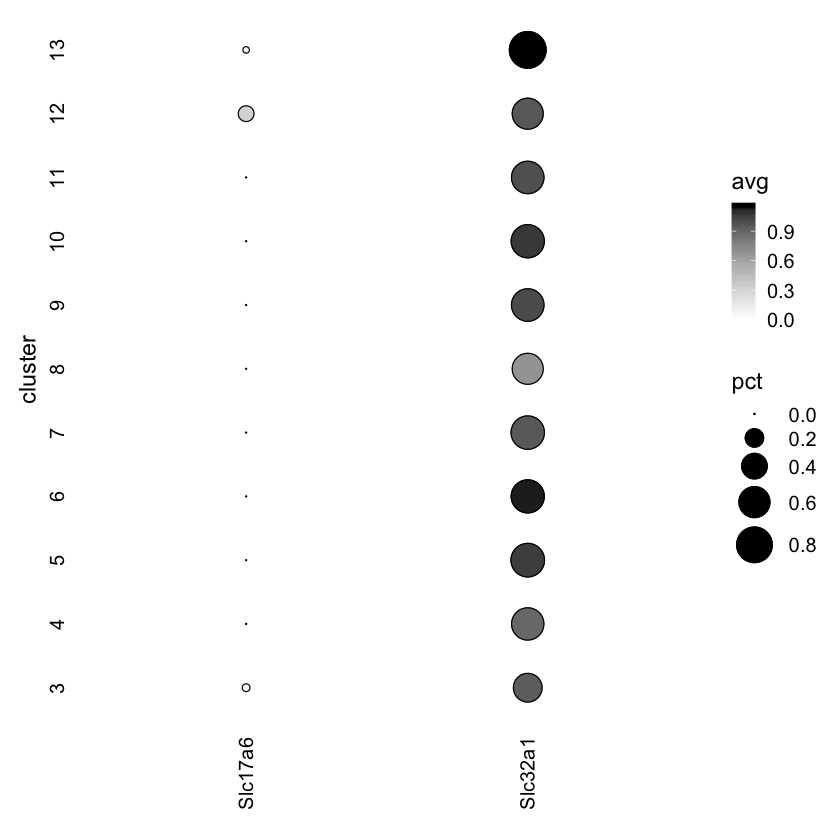

In [6]:
# dotPlot of vglut, vgat, etc. -- Supplementary Figure 2L

genes <- c('Slc17a6', 'Slc32a1')

clust.avg <- AverageExpression(tsne, genes.use = genes, return.seurat = F)
clust.avg <- expm1(clust.avg[,3:13])
subs.melt <- cbind(melt(as.matrix(clust.avg), id.vars = "names"), melt(as.matrix(pct[rownames(clust.avg),3:13]), id.vars = "names"))
subs.melt <- subs.melt[,c(1:3,6)]
names(subs.melt) <- c("gene", "cluster", "avg", "pct")

grey <- gray.colors(256, start = 1, end = 0, gamma = 2, alpha = NULL)
ggplot(subs.melt, aes(gene, factor(cluster))) + geom_point(aes(size = pct, colour=avg)) + scale_color_gradientn(colors=(grey)) + geom_point(aes(size = pct), pch=21, color="black") + scale_size_continuous(range = c(0,10)) + theme(axis.line = element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5), axis.text.y = element_text(angle = 90, hjust = 0.5), axis.ticks.x = element_blank(), axis.ticks.y = element_blank()) + labs(y = "cluster", x = element_blank())
ggsave(paste0("/basiri/BNST/figs/clusterMarkers/dotPlot/180304_MLB005.BNST.tree.markers.dotPlot.pdf"), dpi = 300, limitsize = F)

In [7]:
# plot pct distribution of cells per cluster for specified gene -- Figure 5F and Supplementary Figure 2J

gene = "Pnoc"

tsne.cells <- rownames(tsne@data.info)
raw.data <- as.matrix(tsne@raw.data)
raw.data <- raw.data[,tsne.cells]

## count distribution for gene

tsne.gene <- subset(t(raw.data), raw.data[gene,] >= 1)
tsne.gene <- (t(tsne.gene))
tsne.gene.cells <- colnames(tsne.gene)

gene <- SubsetData(tsne, tsne.gene.cells)

## number of gene positive cells per cluster

sum.gene <- c(NA)
sum.gene.list <- list()
for(i in 1:max(tsne@ident)){sum.gene <- sum(gene@ident == i)
                assign(paste0('sum.gene.',i), sum.gene)
        sum.gene.list[[i]] <- sum.gene                         
        setNames(sum.gene.list, paste0('sum.gene.',i))}

## number of total cells per cluster

sum.all <- c(NA)
sum.all.list <- list()
for(i in 1:max(tsne@ident)){sum.all <- sum(tsne@ident == i)
                assign(paste0('sum.all.',i), sum.all)
        sum.all.list[[i]] <- sum.all                         
        setNames(sum.all.list, paste0('sum.all.',i))}


## overlay of num total and num gene positive
    pdf("/basiri/BNST/figs/pnoc/180304_minCellGene10.maxUMI20000.minGene500.maxMito05.tsne.perp30.res1.3.tree.numCells.all.Pnoc.pdf")    
    barplot(t(as.matrix(sum.gene.list)), col=rgb(0, 0, 0, .5), ylim=c(0,600), border = NA, space=0.1) 
    barplot(t(as.matrix(sum.all.list)), col=rgb(0, 0, 0, .5), ylim=c(0,600), border = NA, space=0.1, add=TRUE) 
    dev.off()

## pct gene positive cells per cluster

pct.gene <- c(NA)
pct.gene.list <- list()
for(i in 1:max(tsne@ident)){pct.gene <- ((sum.gene.list[[i]])/(sum.all.list[[i]]))*100
                assign(paste0('pct.gene.',i), pct.gene)
        pct.gene.list[[i]] <- pct.gene                         
        setNames(pct.gene.list, paste0('pct.gene.',i))}

    pdf("/basiri/BNST/figs/pnoc/180304_minCellGene10.maxUMI20000.minGene500.maxMito05.tsne.perp30.res1.3.tree.pct.Pnoc.pdf")    
    barplot(t(as.matrix(pct.gene.list)), col=rgb(0, 0, 0, .5), ylim=c(0,100), border = NA, space=0.1) 
    dev.off()

## gene positive cell distribution by cluster

pct.gene.cluster <- c(NA)
pct.gene.cluster.list <- list()
for(i in 1:max(tsne@ident)){pct.gene.cluster <- ((sum.gene.list[[i]])/(length(tsne.gene.cells)))*100
                assign(paste0('pct.gene.cluster.',i), pct.gene.cluster)
        pct.gene.cluster.list[[i]] <- pct.gene.cluster                         
        setNames(pct.gene.cluster.list, paste0('pct.gene.cluster.',i))}
    
    pdf("/basiri/BNST/figs/pnoc/180304_minCellGene10.maxUMI20000.minGene500.maxMito05.tsne.perp30.res1.3.tree.pct.Pnoc.dist.pdf")    
    barplot(t(as.matrix(pct.gene.cluster.list)),ylim=c(0,100), border = NA, space=0.1)
    dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

In [8]:
# marker coexpression

tsne.cells <- rownames(tsne@data.info)
raw.data <- as.matrix(tsne@raw.data)
raw.data <- raw.data[,tsne.cells]

Pnoc.cells <- names(which(raw.data["Pnoc",] != 0) > 0)
raw.Pnoc <- raw.data[,Pnoc.cells]

Camk2a.cells <- names(which(raw.data["Camk2a",] != 0) > 0)
raw.Camk2a <- raw.data[,Camk2a.cells]

Slc17a6.Pnoc.cells <- names(which(raw.Pnoc["Slc17a6",] != 0) > 0)
Slc32a1.Pnoc.cells <- names(which(raw.Pnoc["Slc32a1",] != 0) > 0)
Slc17a6.Slc32a1.Pnoc.cells <- intersect(Slc17a6.Pnoc.cells, Slc32a1.Pnoc.cells)

cat(paste0("pct Slc17a6 positive Pnoc cells: "),length(Slc17a6.Pnoc.cells)/length(Pnoc.cells),"\n")
cat(paste0("pct Slc32a1 positive Pnoc cells: "),length(Slc32a1.Pnoc.cells)/length(Pnoc.cells),"\n")
cat(paste0("pct Slc17a6 & Slc32a1 positive Pnoc cells: "),length(Slc17a6.Slc32a1.Pnoc.cells)/length(Pnoc.cells),"\n")

Sst.Pnoc.cells <- names(which(raw.Pnoc["Sst",] != 0) > 0)
cat(paste0("pct Sst positive Pnoc cells: "),length(Sst.Pnoc.cells)/length(Pnoc.cells),"\n")

Prkcd.Pnoc.cells <- names(which(raw.Pnoc["Prkcd",] != 0) > 0)
cat(paste0("pct Prkcd positive Pnoc cells: "),length(Prkcd.Pnoc.cells)/length(Pnoc.cells),"\n")

Pnoc.Camk2a.cells <- names(which(raw.Camk2a["Pnoc",] != 0) > 0)
cat(paste0("pct Pnoc positive Camk2a cells: "),length(Pnoc.Camk2a.cells)/length(Camk2a.cells),"\n")

pct Slc17a6 positive Pnoc cells:  0.03812317 
pct Slc32a1 positive Pnoc cells:  0.7595308 
pct Slc17a6 & Slc32a1 positive Pnoc cells:  0 
pct Sst positive Pnoc cells:  0.2140762 
pct Prkcd positive Pnoc cells:  0.04398827 
pct Pnoc positive Camk2a cells:  0.2503577 
